# Intro to keras as part of Tensorflow
    - Load MNIST dataset
    - Linear model
    - Neural model
    - Convolutional model

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


Tensorflow version:  1.2.1


In [2]:
# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13622482850577915443
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 139919360
locality {
  bus_id: 1
}
incarnation: 13400290179704967864
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:05:00.0"
]


## Get some data

In [3]:
# Import mnist dataset and rescale between [0,1]
from tensorflow.contrib.keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path='mnist.npz')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('X train shape: ',X_train.shape)
print('y train shape: ',y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (60000, 28, 28)
y train shape:  (60000,)
X test shape:  (10000, 28, 28)
y test shape:  (10000,)


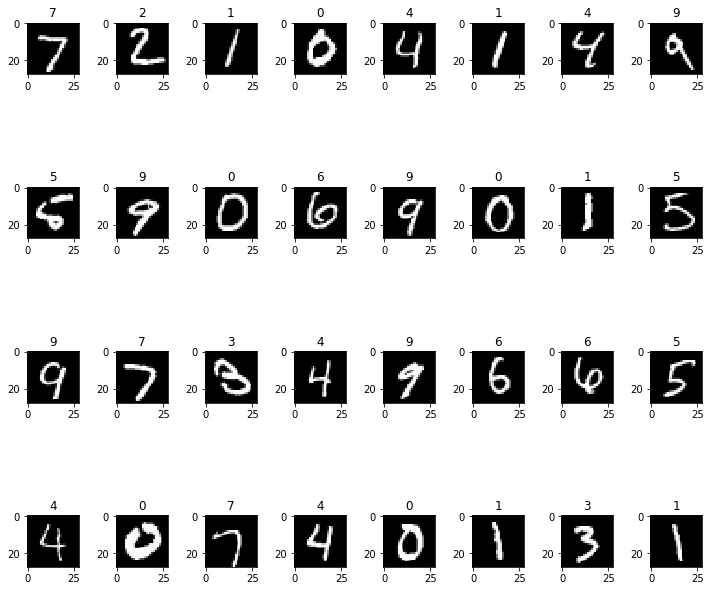

In [4]:
#Examine the data
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title(str(y_test[i]))
    fig.tight_layout()
    plt.imshow(X_test[i])
    

## Linear model

In [5]:
from tensorflow.contrib.keras import models, layers, optimizers, callbacks

print('Linear model...')
images = layers.Input(batch_shape=(None, 28, 28), dtype='float32', name='Images') 
flat = layers.Flatten(name='Flat_image')(images)
output = layers.Dense(10, activation='softmax', name='Dense_output')(flat)

# Model Architecture defined
model_linear = models.Model(inputs=images, outputs=output)
model_linear.summary()


Linear model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28)            0         
_________________________________________________________________
Flat_image (Flatten)         (None, 784)               0         
_________________________________________________________________
Dense_output (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Select optimizer and compile model
sgd_optimizer = optimizers.SGD(lr=0.01)
model_linear.compile(loss='sparse_categorical_crossentropy', 
                     optimizer=sgd_optimizer, metrics=['accuracy'])

In [7]:
# Train the model
start = time.time()

tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/keras/linear/')

history_linear = model_linear.fit(X_train, y_train, batch_size=128, epochs=50,
                                  verbose=1, validation_data=(X_test, y_test), callbacks=[tb_callback_ln])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 1.2665 - acc: 0.7039 - val_loss: 0.8011 - val_acc: 0.8346
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.7095 - acc: 0.8433 - val_loss: 0.6003 - val_acc: 0.8645
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.5823 - acc: 0.8612 - val_loss: 0.5204 - val_acc: 0.8762
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.5215 - acc: 0.8700 - val_loss: 0.4755 - val_acc: 0.8825
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.4846 - acc: 0.8756 - val_loss: 0.4464 - val_acc: 0.8875
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.4593 - acc: 0.8801 - val_loss: 0.4258 - val_acc: 0.8910
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.4405 - acc: 0.8838 - val_loss: 0.4098 - val_acc: 0.8944
Epoch 8/50
60000/60000 [==============================] - 1s 

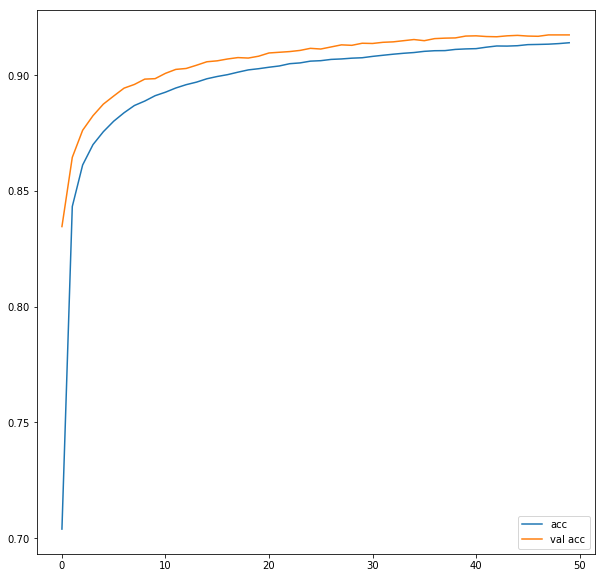

In [8]:
plt.plot(history_linear.history['acc'], label='acc')
plt.plot(history_linear.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Score and select prediction with max prob
import numpy as np
p_test = model_linear.predict(X_test)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,pred_test))

[[ 960    0    2    2    0    4    9    1    2    0]
 [   0 1104    2    2    1    3    4    1   18    0]
 [   9    6  909   13   15    1   15   15   42    7]
 [   3    1   23  916    0   26    3   12   17    9]
 [   1    3    5    1  915    0   10    2    9   36]
 [  11    4    5   33    8  768   15    8   32    8]
 [  12    3    5    2   12   11  910    1    2    0]
 [   2   12   22    7    7    1    0  938    4   35]
 [   6    9    7   23    9   23   12   14  858   13]
 [  11    7    3   12   41    8    0   24    7  896]]


## Neural network model 

In [10]:
print('NN model...')

images = layers.Input(batch_shape=(None, 28, 28), dtype='float32', name='Images') 
flat   = layers.Flatten(name='Flat_image')(images)
dense  = layers.Dense(500, activation='relu', name='Dense_layer')(flat)
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense)

# Model Architecture defined
model_nn = models.Model(inputs=images, outputs=output)
model_nn.summary()


NN model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28)            0         
_________________________________________________________________
Flat_image (Flatten)         (None, 784)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 500)               392500    
_________________________________________________________________
Dense_output (Dense)         (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


In [11]:
sgd_optimizer = optimizers.SGD(lr=0.01)
model_nn.compile(loss='sparse_categorical_crossentropy', 
                 optimizer=sgd_optimizer, metrics=['accuracy'])


In [12]:
# Train the model
start = time.time()

tb_callback_nn = callbacks.TensorBoard(log_dir='/tmp/tensorboard/keras/neural/')

history_nn = model_nn.fit(X_train, y_train, batch_size=128, epochs=50,
                    verbose=1, validation_data=(X_test, y_test), callbacks=[tb_callback_nn])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 1.1033 - acc: 0.7563 - val_loss: 0.5973 - val_acc: 0.8671
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.5221 - acc: 0.8719 - val_loss: 0.4329 - val_acc: 0.8905
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.4209 - acc: 0.8888 - val_loss: 0.3748 - val_acc: 0.9005
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.3754 - acc: 0.8979 - val_loss: 0.3410 - val_acc: 0.9077
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.3473 - acc: 0.9039 - val_loss: 0.3206 - val_acc: 0.9121
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.3273 - acc: 0.9092 - val_loss: 0.3036 - val_acc: 0.9168
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.3115 - acc: 0.9133 - val_loss: 0.2920 - val_acc: 0.9206
Epoch 8/50
60000/60000 [==============================] - 1s 

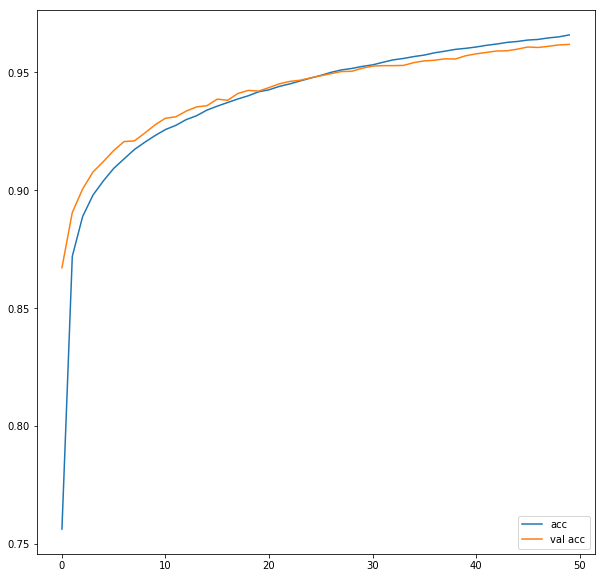

In [13]:
plt.plot(history_nn.history['acc'], label='acc')
plt.plot(history_nn.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

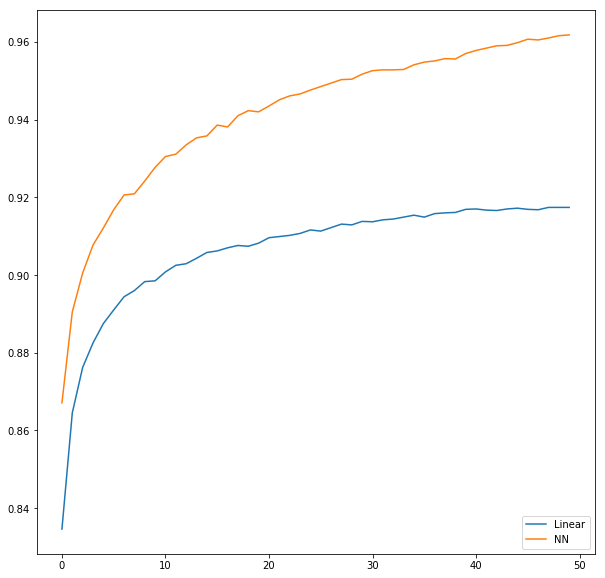

In [14]:
# Compare the two models
plt.plot(history_linear.history['val_acc'], label='Linear')
plt.plot(history_nn.history['val_acc'], label='NN')
plt.legend(loc='lower right')
plt.show()

## Convolutional model

In [15]:
#Define the model
print('Convolutional model...')
print('LeNet architecture.')

#Inputs
images = layers.Input(batch_shape=(None, 28, 28, 1), dtype='float32', name='Images')

#First convolutional layer
conv1 = layers.Conv2D(20, (5,5))(images)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#Second convolutional layer
conv2 = layers.Conv2D(20, (5,5))(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#Flatten convolution output
flat = layers.Flatten(name='Flat_image')(pool2)

# First dense layer
dense1 = layers.Dense(500, activation='relu', name='Dense_1')(flat)

# Second dense layer
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense1)

# Model Architecture defined
model_conv = models.Model(inputs=images, outputs=output)
model_conv.summary()


Convolutional model...
LeNet architecture.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
Flat_image (Flatten)         (None, 320)               0         
_________________________________________________________________
Dense_1 (Dense)              (Non

In [16]:
# Compile model and select optimizer
sgd_optimizer = optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_conv.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])


In [17]:
# Train the model
X_train_img = X_train.reshape(X_train.shape[0], 28, 28, 1) 
X_test_img = X_test.reshape(X_test.shape[0], 28, 28, 1)

start = time.time()

tb_callback_cnn = callbacks.TensorBoard(log_dir='/tmp/tensorboard/keras/CNN/')

history = model_conv.fit(X_train_img, y_train, batch_size=128, epochs=10,
                    verbose=1, validation_data=(X_test_img, y_test), callbacks=[tb_callback_cnn])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.2998 - acc: 0.9173 - val_loss: 0.0657 - val_acc: 0.9791
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.0489 - acc: 0.9857 - val_loss: 0.0459 - val_acc: 0.9858
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.0268 - acc: 0.9921 - val_loss: 0.0393 - val_acc: 0.9876
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.0186 - acc: 0.9944 - val_loss: 0.0377 - val_acc: 0.9880
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.0135 - acc: 0.9960 - val_loss: 0.0371 - val_acc: 0.9902
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0363 - val_acc: 0.9899
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.0086 - acc: 0.9979 - val_loss: 0.0350 - val_acc: 0.9906
Epoch 8/10
60000/60000 [==============================] - 2s 

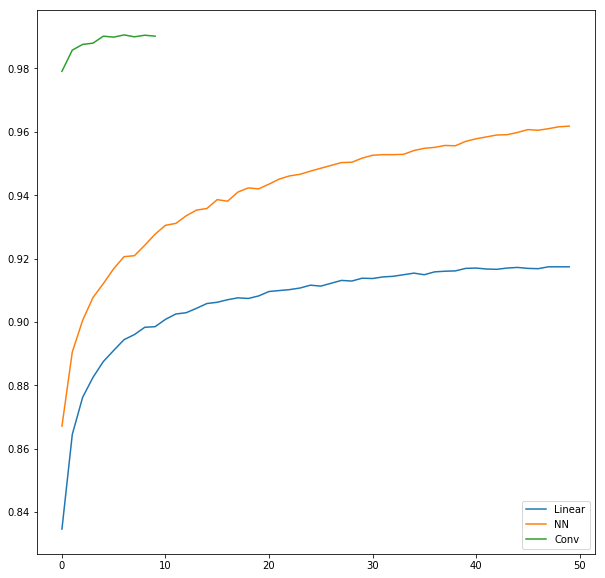

In [18]:
#Compare with previous
# Compare the two models
plt.plot(history_linear.history['val_acc'], label='Linear')
plt.plot(history_nn.history['val_acc'], label='NN')
plt.plot(history.history['val_acc'], label='Conv')
plt.legend(loc='lower right')
plt.show()


In [20]:
# Score and select prediction with max prob
import numpy as np
p_test = model_conv.predict(X_test_img)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_test))

[[ 974    0    0    0    0    0    1    3    2    0]
 [   0 1130    2    0    0    0    1    1    1    0]
 [   1    2 1022    0    1    0    0    3    3    0]
 [   0    0    1  999    0    6    0    2    2    0]
 [   0    0    0    0  974    0    3    0    0    5]
 [   2    0    0    4    0  881    1    1    3    0]
 [   5    2    0    0    2    1  948    0    0    0]
 [   0    3    4    0    0    0    0 1018    0    3]
 [   3    0    3    0    0    1    1    2  962    2]
 [   1    0    0    0    5    2    0    4    3  994]]


n:  1 - Pred 1: 5(0.794) - Pred 2: 3(0.204)
n:  2 - Pred 1: 9(0.941) - Pred 2: 4(0.059)
n:  3 - Pred 1: 6(0.561) - Pred 2: 4(0.355)
n:  4 - Pred 1: 5(0.997) - Pred 2: 3(0.003)
n:  5 - Pred 1: 6(0.358) - Pred 2: 0(0.299)
n:  6 - Pred 1: 2(0.775) - Pred 2: 8(0.214)
n:  7 - Pred 1: 4(0.635) - Pred 2: 6(0.365)
n:  8 - Pred 1: 1(0.463) - Pred 2: 7(0.352)
n:  9 - Pred 1: 9(0.356) - Pred 2: 5(0.324)
n: 10 - Pred 1: 9(0.556) - Pred 2: 4(0.444)
n: 11 - Pred 1: 8(0.790) - Pred 2: 9(0.210)
n: 12 - Pred 1: 7(0.800) - Pred 2: 9(0.179)
n: 13 - Pred 1: 9(0.985) - Pred 2: 8(0.012)
n: 14 - Pred 1: 5(0.982) - Pred 2: 9(0.011)
n: 15 - Pred 1: 1(0.951) - Pred 2: 2(0.026)
n: 16 - Pred 1: 6(0.998) - Pred 2: 4(0.002)
n: 17 - Pred 1: 2(0.996) - Pred 2: 7(0.003)
n: 18 - Pred 1: 4(0.968) - Pred 2: 1(0.021)
n: 19 - Pred 1: 1(0.485) - Pred 2: 2(0.382)
n: 20 - Pred 1: 7(0.996) - Pred 2: 5(0.003)
n: 21 - Pred 1: 0(0.484) - Pred 2: 8(0.401)
n: 22 - Pred 1: 3(0.996) - Pred 2: 5(0.004)
n: 23 - Pred 1: 7(0.856) - Pred 

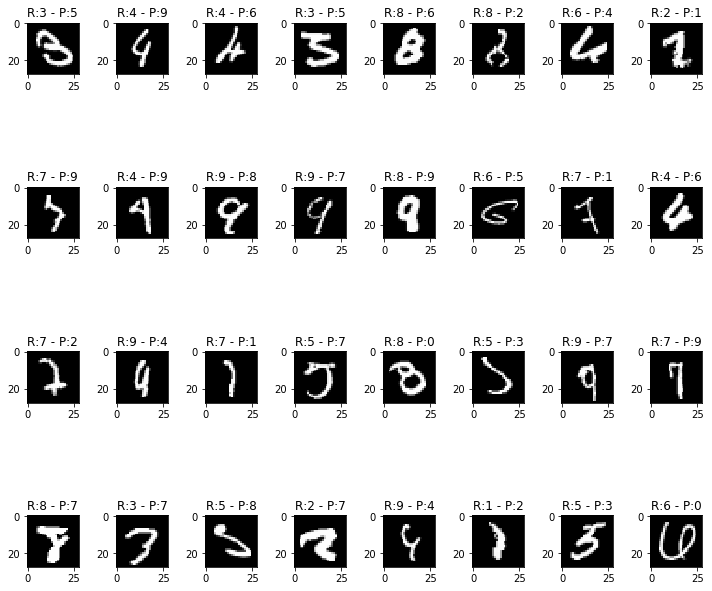

In [43]:

#Print probabilities to the first erros
test_errors=[]
test_errors_real=[]
test_errors_predict=[]
num_errors = 32
n = 0
for i in range(len(pred_test)):
    if pred_test[i] != y_test[i] and n < num_errors: #Error!
        n += 1
        test_errors += [X_test_img[i,:,:,0]]
        test_errors_real += [y_test[i]]
        test_errors_predict += [pred_test[i]]
        
        #Print first propabilities
        index = p_test[i].argsort()[::-1]
        print('n: %2i - Pred 1: %1i(%0.3f) - Pred 2: %1i(%0.3f)' % (n,
              index[0], p_test[i][index[0]], index[1], p_test[i][index[1]]))
        
print("Num errors: ", len(test_errors))


#Plot 32 images wrong classified.
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title('R:'+str(test_errors_real[i])+' - P:'+str(test_errors_predict[i]))
    fig.tight_layout()
    plt.imshow(test_errors[i])
    

# Input batch example
    - Define a batch generator
    - Use it in the train process

In [22]:
# New model. Equal to the last.
model_conv2 = models.Model(inputs=images, outputs=output)

sgd_optimizer = optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_conv2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])


In [23]:
# Define a generator to X_train. Same code to an HDF5 source
def batch_generator(X, y, batch_size=64):
    data_size = X.shape[0]
    while 1:
        # Randomize batches in each epoch
        batch_randomized = np.random.permutation(range(0, data_size-batch_size, batch_size))
        # Iterate over each batch
        for batch in batch_randomized:
            x_batch = X[batch : batch+batch_size]
            y_batch = y[batch : batch+batch_size]
            yield x_batch, y_batch

In [24]:
#Test the generator
seq = batch_generator(X_train_img, y_train)    
next_seq = next(seq)
print(next_seq[0][0].shape)
print(next_seq[1])


(28, 28, 1)
[1 8 4 2 1 3 7 9 5 3 7 3 4 5 4 5 2 0 6 7 9 9 3 5 4 0 5 6 7 4 6 1 7 1 6 2 6
 8 0 1 9 5 5 0 4 1 6 2 7 3 6 4 8 5 2 6 1 7 2 8 0 9 6 0]


In [25]:
# Train using the fit_generator function

# Number of steps to use all the train data in a epoch.
steps = X_train.shape[0]//64

history = model_conv2.fit_generator(batch_generator(X_train_img, y_train, batch_size=64),
                                    steps_per_epoch=steps, epochs=10,
                                    verbose=1, validation_data=(X_test_img, y_test))


Epoch 1/10
937/937 [==============================] - 5s - loss: 0.1416 - acc: 0.9680 - val_loss: 0.0783 - val_acc: 0.9766
Epoch 2/10
937/937 [==============================] - 5s - loss: 0.0419 - acc: 0.9879 - val_loss: 0.0409 - val_acc: 0.9876
Epoch 3/10
937/937 [==============================] - 5s - loss: 0.0191 - acc: 0.9946 - val_loss: 0.0351 - val_acc: 0.9899
Epoch 4/10
937/937 [==============================] - 5s - loss: 0.0119 - acc: 0.9968 - val_loss: 0.0354 - val_acc: 0.9889
Epoch 5/10
937/937 [==============================] - 5s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0341 - val_acc: 0.9909
Epoch 6/10
937/937 [==============================] - 5s - loss: 0.0068 - acc: 0.9983 - val_loss: 0.0341 - val_acc: 0.9912
Epoch 7/10
937/937 [==============================] - 5s - loss: 0.0058 - acc: 0.9987 - val_loss: 0.0340 - val_acc: 0.9910
Epoch 8/10
937/937 [==============================] - 5s - loss: 0.0050 - acc: 0.9990 - val_loss: 0.0345 - val_acc: 0.9910
Epoch 9/10
937/9